# Assignment 1 
### Mia Miletić (63240481)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

Data preprocessing:

In [ ]:
file_path = r'.\podatki_PM.csv'
df = pd.read_csv(file_path)

df = df.drop(columns=['Datum']) #Remove 'Datum' column
df.fillna(df.mean(), inplace=True) #Fill NaN values with mean of the column
df.head()

,Glob_sevanje_mean,Hitrost_vetra_mean,Sunki_vetra_max,Padavine_sum,Vlaga_mean,Temperatura_Krvavec_mean,Temperatura_lokacija_mean,PM10,PM_vceraj,sinD,cosD
0,0.125,0.6750,2.9,0.0,79.1750,-2.9875,3.2000,44.3,51.4,0.034899,0.999391
1,0.375,0.7375,2.6,0.0,93.5625,-4.5250,2.8750,49.0,44.3,0.052336,0.998630
2,0.875,0.8875,3.2,0.0,93.3000,2.9625,0.6875,61.3,49.0,0.069756,0.997564
3,0.750,1.0000,4.5,0.0,94.2625,2.9875,0.5875,38.9,61.3,0.087156,0.996195
4,0.250,0.5750,2.3,0.0,87.6500,-0.2500,3.1625,30.3,38.9,0.104528,0.994522


We set 'PM10' to be target variable and then split the dataset on train and test data. As the data is temporal do not perform random shuffle. 

In [ ]:
x = df.drop(columns=['PM10']) #Set attributes
y = df['PM10'] #Set target variable to 'PM10'

#Split the dataset into training and testing sets without shuffling
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=False)

Linear regression implemenations

In [ ]:
### Linear regression using the sklearn implementation
linear_regressor = LinearRegression()
linear_regressor.fit(x_train, y_train)

y_pred = linear_regressor.predict(x_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)

### Linear regression using the custom implementation
def myfit(x,y):
    # beta = (X.T * X)^-1 * (X.T * y)
    x_with_ones = np.c_[np.ones(x.shape[0]), x]
    beta = np.linalg.inv(x_with_ones.T.dot(x_with_ones)).dot(x_with_ones.T).dot(y)
    return beta

def mypredict(x, beta):
    x_with_ones = np.c_[np.ones(x.shape[0]), x]
    return x_with_ones.dot(beta)

beta = myfit(x_train, y_train)
my_pred = mypredict(x_test, beta)
myr2 = r2_score(y_test, my_pred)
mymse = mean_squared_error(y_test, my_pred)
mymae = mean_absolute_error(y_test, my_pred)

# Comparing the two models
print('R2 score from the sklearn model:', r2)
print('R2 score from the custom model:', myr2)
print('The difference between the two models:', abs(r2 - myr2))
print('\nMSE from the sklearn model:', mse)
print('MSE from the custom model:', mymse)
print('The difference between the two models:', abs(mse - mymse))
print('\nMAE from the sklearn model:', mae)
print('MAE from the custom model:', mymae)
print('The difference between the two models:', abs(mae - mymae))

R2 score from the sklearn model: 0.7676374067767091
R2 score from the custom model: 0.7676374067767096
The difference between the two models: 4.440892098500626e-16

MSE from the sklearn model: 69.93122965444485
MSE from the custom model: 69.93122965444472
The difference between the two models: 1.2789769243681803e-13

MAE from the sklearn model: 6.041491247281948
MAE from the custom model: 6.04149124728194
The difference between the two models: 7.993605777301127e-15


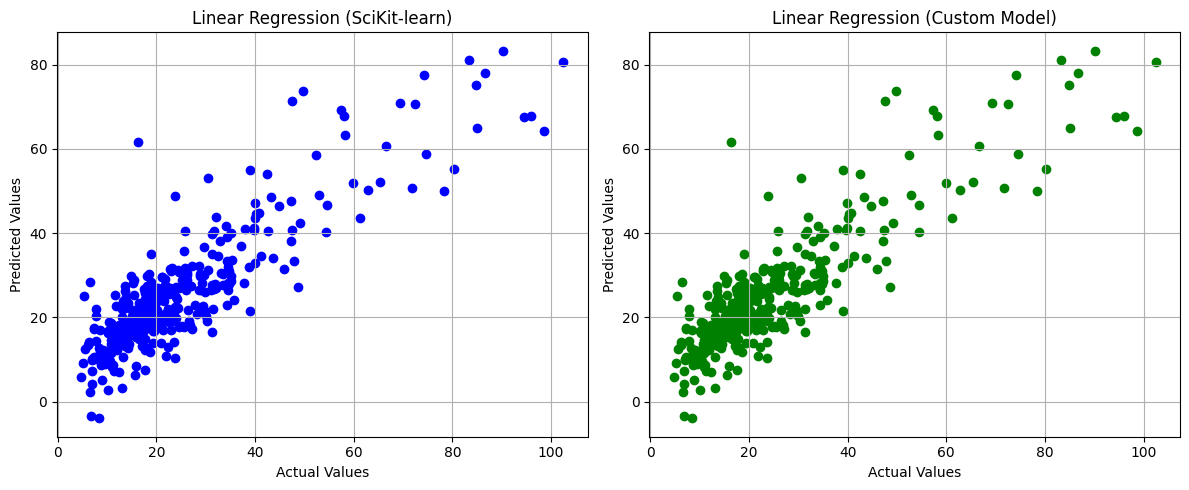

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First subplot (using SciKit-learn linear regression model)
axes[0].scatter(y_test, y_pred, color='blue', label='Actual vs. Predicted')
axes[0].set_xlabel("Actual Values")
axes[0].set_ylabel("Predicted Values")
axes[0].set_title("Linear Regression (SciKit-learn)")
axes[0].grid(True)

# Second subplot (using custom linear regression model)
axes[1].scatter(y_test, my_pred, color='green', label='Actual vs. Predicted')
axes[1].set_xlabel("Actual Values")
axes[1].set_ylabel("Predicted Values")
axes[1].set_title("Linear Regression (Custom Model)")
axes[1].grid(True)

plt.tight_layout()
plt.show()

Base code that we will later use to generate following diagnostic plots: (source: https://www.statsmodels.org/stable/examples/notebooks/generated/linear_regression_diagnostics_plots.html)

In [ ]:
# base code
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type

style_talk = 'seaborn-talk'    #refer to plt.style.available

class LinearRegDiagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Authors:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.

        Matt Spinelli (m3spinelli@gmail.com, where 3 = r)
        (1) Fixed incorrect annotation of the top most extreme residuals in
            the Residuals vs Fitted and, especially, the Normal Q-Q plots.
        (2) Changed Residuals vs Leverage plot to match closer the y-axis
            range shown in the equivalent plot in the R package ggfortify.
        (3) Added horizontal line at y=0 in Residuals vs Leverage plot to
            match the plots in R package ggfortify and base R.
        (4) Added option for placing a vertical guideline on the Residuals
            vs Leverage plot using the rule of thumb of h = 2p/n to denote
            high leverage (high_leverage_threshold=True).
        (5) Added two more ways to compute the Cook's Distance (D) threshold:
            * 'baseR': D > 1 and D > 0.5 (default)
            * 'convention': D > 4/n
            * 'dof': D > 4 / (n - k - 1)
        (6) Fixed class name to conform to Pascal casing convention
        (7) Fixed Residuals vs Leverage legend to work with loc='best'
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-v0_8-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)
        self.nresids = len(self.residual_norm)

    def __call__(self, plot_context='seaborn-v0_8-paper', **kwargs):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(
                ax=ax[1,1],
                high_leverage_threshold = kwargs.get('high_leverage_threshold'),
                cooks_threshold = kwargs.get('cooks_threshold'))
            plt.show()

        return self.vif_table(), fig, ax,

    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.argsort(residual_abs), 0)
        abs_resid_top_3 = abs_resid[:3]
        for i in abs_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        fig = QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for i, x, y in self.__qq_top_resid(QQ.theoretical_quantiles, abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(x, y),
                ha='right',
                color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')

        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None, high_leverage_threshold=False, cooks_threshold='baseR'):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        factors = []
        if cooks_threshold == 'baseR' or cooks_threshold is None:
            factors = [1, 0.5]
        elif cooks_threshold == 'convention':
            factors = [4/self.nresids]
        elif cooks_threshold == 'dof':
            factors = [4/ (self.nresids - self.nparams)]
        else:
            raise ValueError("threshold_method must be one of the following: 'convention', 'dof', or 'baseR' (default)")
        for i, factor in enumerate(factors):
            label = "Cook's distance" if i == 0 else None
            xtemp, ytemp = self.__cooks_dist_line(factor)
            ax.plot(xtemp, ytemp, label=label, lw=1.25, ls='--', color='red')
            ax.plot(xtemp, np.negative(ytemp), lw=1.25, ls='--', color='red')

        if high_leverage_threshold:
            high_leverage = 2 * self.nparams / self.nresids
            if max(self.leverage) > high_leverage:
                ax.axvline(high_leverage, label='High leverage', ls='-.', color='purple', lw=1)

        ax.axhline(0, ls='dotted', color='black', lw=1.25)
        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_ylim(min(self.residual_norm)-0.1, max(self.residual_norm)+0.1)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        plt.legend(loc='best')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        return (vif_df
                .sort_values("VIF Factor")
                .round(2))

    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y

    def __qq_top_resid(self, quantiles, top_residual_indices):
        """
        Helper generator function yielding the index and coordinates
        """
        offset = 0
        quant_index = 0
        previous_is_negative = None
        for resid_index in top_residual_indices:
            y = self.residual_norm[resid_index]
            is_negative = y < 0
            if previous_is_negative == None or previous_is_negative == is_negative:
                offset += 1
            else:
                quant_index -= offset
            x = quantiles[quant_index] if is_negative else np.flip(quantiles, 0)[quant_index]
            quant_index += 1
            previous_is_negative = is_negative
            yield resid_index, x, y


Diagnosing custom linear regression with the diagnostic plots:

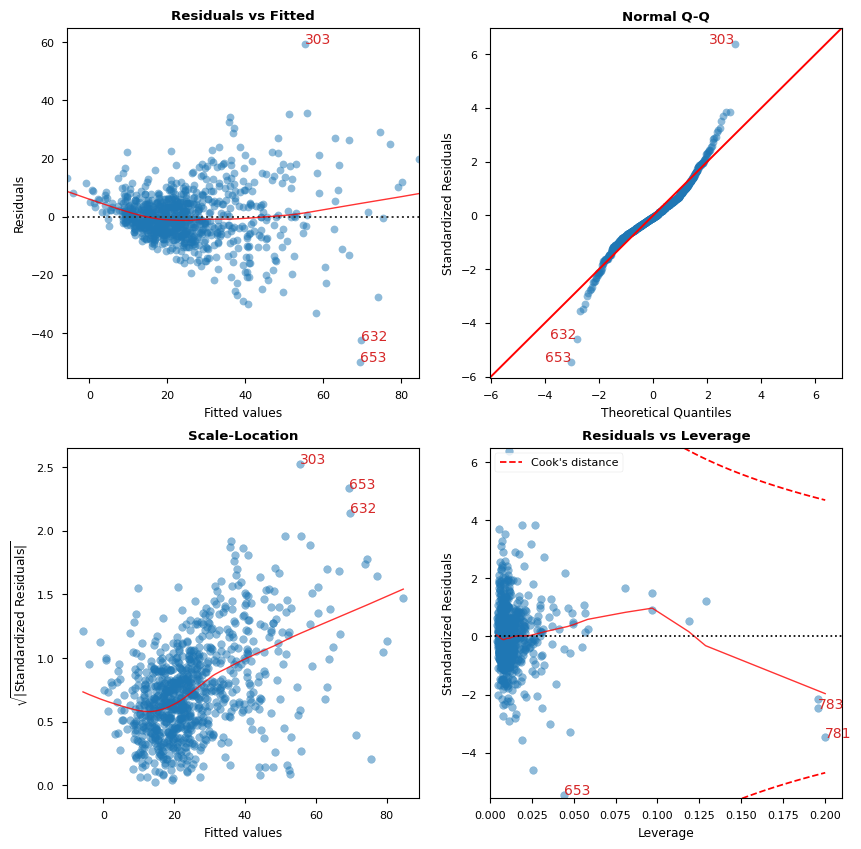

                     Features  VIF Factor
4                Padavine_sum        1.32
8                   PM_vceraj        1.43
5                  Vlaga_mean        1.81
9                        sinD        1.86
1           Glob_sevanje_mean        3.79
2          Hitrost_vetra_mean        4.04
3             Sunki_vetra_max        4.07
6    Temperatura_Krvavec_mean        4.08
10                       cosD        5.93
7   Temperatura_lokacija_mean        7.62
0                       const      190.59


In [ ]:
import statsmodels.api as sm

#setting up the data for diagnostic plots using custom class and OLS model

x_with_ones = sm.add_constant(x_train)  # adding the intercept term
model = sm.OLS(y_train, x_with_ones)  # using OLS model 
results = model.fit()  

cls = LinearRegDiagnostic(results)
vif, fig, ax = cls()
print(vif)

### Can we make some improvements to custom linear regression fit?

We can try to improve the custom linear regression fit by addressing outliers or transforming the target/attributes

 **Removing Outliers**: Identify and remove outliers from the dataset

In [ ]:
from scipy import stats
import numpy as np

z = np.abs(stats.zscore(df)) # Calculate Z-scores for each value in df
df = df[(z < 3).all(axis=1)] # Filter out rows where any attribute has a Z-score 3 or more 

x1 = df.drop(columns=['PM10']) #Set attributes
y1 = df['PM10'] #Set target variable to 'PM10'

#Split the dataset into training and testing sets without shuffling
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.3, shuffle=False)

In [ ]:
# recalculating the custom model after removing outliers
beta1 = myfit(x1_train, y1_train)
my_pred1 = mypredict(x1_test, beta1)
myr21 = r2_score(y1_test, my_pred1)
mymse1 = mean_squared_error(y1_test, my_pred1)
mymae1 = mean_absolute_error(y1_test, my_pred1)

# Comparing the two models
print('R2 score from the custom model:', myr21, '(after removing outliers)')
print('R2 score from the custom model:', myr2)
print('The difference between the two models:', abs(myr21 - myr2))
print('\nMSE from the custom model:', mymse1, '(after removing outliers)')
print('MSE from the custom model:', mymse)
print('The difference between the two models:', abs(mymse1 - mymse))
print('\nMAE from the custom model:', mymae1, '(after removing outliers)')
print('MAE from the custom model:', mymae)
print('The difference between the two models:', abs(mymae1 - mymae))

R2 score from the custom model: 0.6732203819718081 (after removing outliers)
R2 score from the custom model: 0.7676374067767096
The difference between the two models: 0.09441702480490144

MSE from the custom model: 45.00853398983347 (after removing outliers)
MSE from the custom model: 69.93122965444472
The difference between the two models: 24.922695664611254

MAE from the custom model: 5.199488424421811 (after removing outliers)
MAE from the custom model: 6.04149124728194
The difference between the two models: 0.8420028228601293


As we can see, removing outliers using Z-score method, gave as lower results in R2, MSE and MAE, making our model have lower error, if we consider MSE and MAE. In the next plot, we can see the models compared:

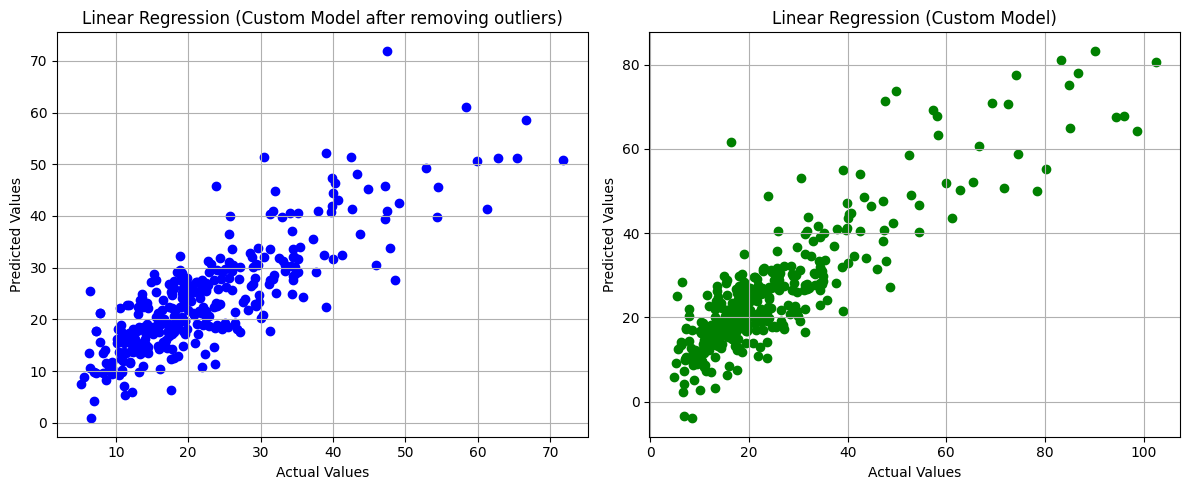

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First subplot (using custom linear regression model, after removing outliers)
axes[0].scatter(y1_test, my_pred1, color='blue', label='Actual vs. Predicted')
axes[0].set_xlabel("Actual Values")
axes[0].set_ylabel("Predicted Values")
axes[0].set_title("Linear Regression (Custom Model after removing outliers)")
axes[0].grid(True)

# Second subplot (using custom linear regression model)
axes[1].scatter(y_test, my_pred, color='green', label='Actual vs. Predicted')
axes[1].set_xlabel("Actual Values")
axes[1].set_ylabel("Predicted Values")
axes[1].set_title("Linear Regression (Custom Model)")
axes[1].grid(True)

plt.tight_layout()
plt.show()

**Transforming Target Variable**: Apply a log transformation to the target variable to stabilize variance and make the data more normally distributed

In [ ]:
y2_train = np.log(y_train)
y2_test = np.log(y_test)

In [ ]:
beta2 = myfit(x_train, y2_train)
my_pred2 = mypredict(x_test, beta2)
myr22 = r2_score(y2_test, my_pred2)
mymse2 = mean_squared_error(y2_test, my_pred2)
mymae2 = mean_absolute_error(y2_test, my_pred2)

# Comparing the two models
print('R2 score from the custom model:', myr22, '(after target var transformation)')
print('R2 score from the custom model:', myr2)
print('The difference between the two models:', abs(myr22 - myr2))

R2 score from the custom model: 0.7158568518969637 (after target var transformation)
R2 score from the custom model: 0.7676374067767096
The difference between the two models: 0.051780554879745866


In this analysis, we applied a logarithmic transformation to the target variable before training the model. 

In the graphs below we can see how Left Graph (log-transformed scale)** has both the actual and predicted values are shown in log scale. The logarithmic transformation helps stabilize variance, resulting in a more tightly clustered pattern of points along the \( y = x \) line. This indicates that the model performs well at predicting the log-transformed target values.

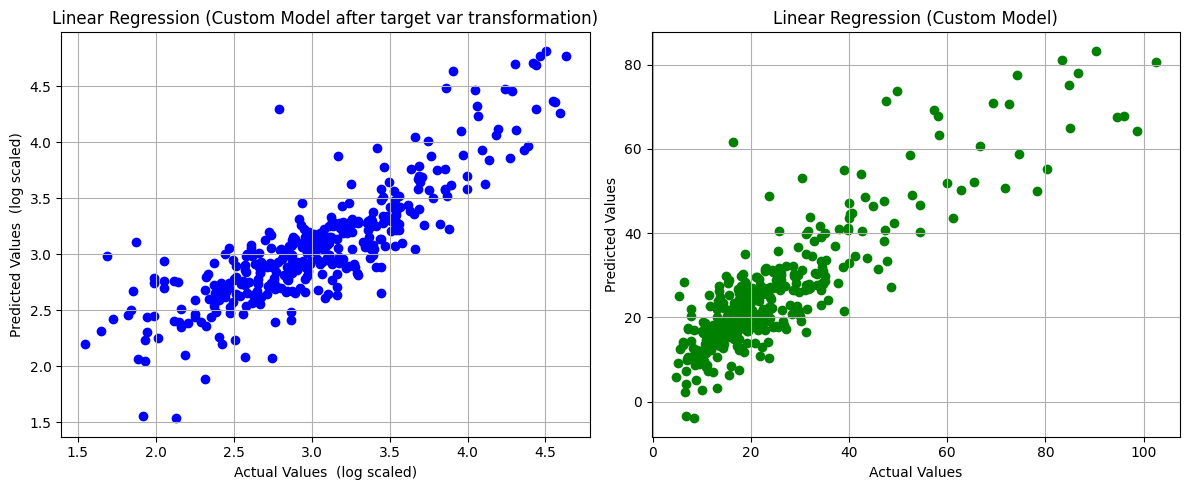

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First subplot (using custom linear regression model, after target var transformation)
axes[0].scatter(y2_test, my_pred2, color='blue', label='Actual vs. Predicted')
axes[0].set_xlabel("Actual Values  (log scaled)")
axes[0].set_ylabel("Predicted Values  (log scaled)")
axes[0].set_title("Linear Regression (Custom Model after target var transformation)")
axes[0].grid(True)

# Second subplot (using custom linear regression model)
axes[1].scatter(y_test, my_pred, color='green', label='Actual vs. Predicted')
axes[1].set_xlabel("Actual Values")
axes[1].set_ylabel("Predicted Values")
axes[1].set_title("Linear Regression (Custom Model)")
axes[1].grid(True)

plt.tight_layout()
plt.show()